# Soil Data
Prepare raster data that store information about soil conditions
- Soil Maps provided by "Federal Institute for Geosciences and Natural Resources"
- Data Preparation

Source:
- [Datasets available here](https://produktcenter.bgr.de/terraCatalog/Start.do)
- [Interaktive map](https://geoviewer.bgr.de/mapapps4/resources/apps/geoviewer/index.html?lang=de&tab=boden&cover=boden_1000-5000&layers=boden_buek5000_container,boden_bgl5000_ags,-boden_buek1000_container,-boden_buek5000_ags)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray
from pyproj import CRS, transform
from geocube.api.core import make_geocube
import os
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, shape
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
xr.set_options(display_style="html")

### Load Soil Data

In [3]:
# get all tif files available in directory BGR
PATH_DIR = "./data/SoilData"
tif_files = list()
esri_files = list()

for _dir in os.listdir(PATH_DIR):
    if os.path.isdir(f"{PATH_DIR}/{_dir}") and _dir != "germany_soil":
        if _dir == "DWD_BMVI-ExpN_WBEFFMaiAugENS16":
            for file in os.listdir(f"{PATH_DIR}/{_dir}"):
                if "2031-2060" in file and file.endswith(".tif"):
                    tif_files.append(f"{PATH_DIR}/{_dir}/{file}")
        else:
            for file in os.listdir(f"{PATH_DIR}/{_dir}"):
                if file.endswith(".tif"):
                    tif_files.append(f"{PATH_DIR}/{_dir}/{file}")
                elif file.endswith(".shp"):
                    esri_files.append(f"{PATH_DIR}/{_dir}/{file}")

esri_files, tif_files

(['./data/SoilData/hyraum_v32/hyraum_tr__v32_poly.shp',
  './data/SoilData/hyraum_v32/hyraum_gr__v32_poly.shp',
  './data/SoilData/hyraum_v32/hyraum_r__v32_poly.shp',
  './data/SoilData/buek1000en_v21/buek1000en_v21.shp',
  './data/SoilData/GEOGW1000_v1/geogw1000_besch__v11_poly.shp',
  './data/SoilData/HY1000_v12/hy1000_hydrogeo_lith_v12_poly.shp',
  './data/SoilData/boart1000_ob_v20/boart1000_ob_v20.shp',
  './data/SoilData/humus1000_ob_v20/humus1000_ob_v20.shp',
  './data/SoilData/bag5000ob_v30/bag5000ob.shp'],
 ['./data/SoilData/WVPFL1000_250/WVPFL1000_250.tif',
  './data/SoilData/We1000_250/we1000_250.tif',
  './data/SoilData/DWD_BMVI-ExpN_WBEFFMaiAugENS16/DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL15_2031-2060_v11.tif',
  './data/SoilData/DWD_BMVI-ExpN_WBEFFMaiAugENS16/DWD_BMVI-ExpN_WBEFFMaiAug_ENS16MEAN_2031-2060_v11.tif',
  './data/SoilData/DWD_BMVI-ExpN_WBEFFMaiAugENS16/DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL85_2031-2060_v11.tif',
  './data/SoilData/KA1000_250/ka1000_250.tif',
  './data/S

In [4]:
data_sets = list()

for tif_file in tif_files:
    da = xr.open_rasterio(tif_file).compute()
    # replace no data values with nan
    try:
        for non_val in da.attrs["nodatavals"]:
            da = da.where(da!=non_val, np.NaN)
            
        del da.attrs["nodatavals"]
    except KeyError:
        pass
    try:
        da = da.where(da!=da.attrs["_FillValue"], np.NaN)
        del da.attrs["_FillValue"]
    except KeyError:
        pass     
    
    inProj = CRS(da.attrs["crs"])
    outProj = CRS('EPSG:32632')

    def transform_crs(x1:float, y1:float):
        """EPSG 32632 from CRS from TIF File"""
        x2, y2 = transform(inProj, outProj, x1, y1)
        return [x2, y2]
    
    x_coords_transformed = list()
    y_coords_transformed = list()
    for x in da.x.values:
        x_coords_transformed.append(transform_crs(x, da.y.values[0])[0])
    for y in da.y.values:
        y_coords_transformed.append(transform_crs(da.x.values[0], y)[1])
    # assign transformed coords
    da = da.assign_coords(x=x_coords_transformed, y=y_coords_transformed)
    data_sets.append(da.to_dataset(name=tif_file.split("/")[-1].split(".")[0]))

ds_merge = xr.merge(data_sets)
ds_merge = ds_merge.where(ds_merge.isnull() == False, drop=True)
ds_merge = ds_merge.squeeze('band').drop('band')

ds_merge

<xarray.Dataset>
Dimensions:                                              (y: 6819, x: 5075)
Coordinates:
  * y                                                    (y) float64 5.232e+0...
  * x                                                    (x) float64 2.752e+0...
Data variables: (12/13)
    WVPFL1000_250                                        (y, x) float32 nan ....
    we1000_250                                           (y, x) float32 nan ....
    DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL15_2031-2060_v11  (y, x) float32 nan ....
    DWD_BMVI-ExpN_WBEFFMaiAug_ENS16MEAN_2031-2060_v11    (y, x) float32 nan ....
    DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL85_2031-2060_v11  (y, x) float32 nan ....
    ka1000_250                                           (y, x) float32 nan ....
    ...                                                   ...
    NFKWe1000_250                                        (y, x) float32 nan ....
    PhysGru1000_250                                      (y, x) float32 nan ....
    FOBIP3dm1000_250                                     (y, x) float32 nan ....
    FK10dm1000_250                                       (y, x) float32 nan ....
    swr1000_250                                          (y, x) float32 nan ....
    lkwe1000_250                                         (y, x) float32 nan ....

In [5]:
# variablen umbenennen
ds_merge = ds_merge.rename({
    "we1000_250": "effective_rooting_depth", 
    "ka1000_250": "capillary_rise_from_groundwater_into_effective_rooting_zone", 
    "GWS1000_250": "groundwater_influence", 
    "FK10dm1000_250": "water_field_capacity", 
    "lkwe1000_250": "content_air_in_soil",
    "NFKWe1000_250": "available_water_holding_capacity",
    "WVPFL1000_250": "plant_available_water_summer",
    "PhysGru1000_250": "soil_depth",
    "FOBIP3dm1000_250": "relative_binding_strength_isoproturon",
    "swr1000_250": "rate_percolation",
    'DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL15_2031-2060_v11': 'effective_water_balance_may_aug_2031-2060_15percentile',
    'DWD_BMVI-ExpN_WBEFFMaiAug_ENS16MEAN_2031-2060_v11': 'effective_water_balance_may_aug_2031-2060_mean',
    'DWD_BMVI-ExpN_WBEFFMaiAug_ENS16PCTL85_2031-2060_v11': 'effective_water_balance_may_aug_2031-2060_85percentile',
})

### Combine Raster and Vector Data
#### ESRI Shape Maps for GeoPandas usage

In [6]:
gpd_dfs = list()
for shp_file in esri_files:
    #if "hyraum" not in shp_file:
    _gdf = gpd.read_file(shp_file).to_crs('EPSG:4326')
    _gdf["data"] = shp_file
    if shp_file == f"{PATH_DIR}/GEOGW1000_v1/geogw1000_besch__v11_poly.shp":
        sub_frames = list()
        sub_frames.append(_gdf[["haerte_id", "haerte", "Shape_STAr", "Shape_STLe", "geometry"]].reset_index(drop=True))
        sub_frames.append(_gdf[["geogen_id", "Shape_STAr", "Shape_STLe", "geometry"]].reset_index(drop=True))
        sub_frames.append(_gdf[["gmin_id", "gmin_txt", "Shape_STAr", "Shape_STLe", "geometry"]].reset_index(drop=True))
        sub_frames.append(_gdf[["chem_id", "chem_txt", "Shape_STAr", "Shape_STLe", "geometry"]].reset_index(drop=True))
        #pd.concat([pd.json_normalize(frame) for frame in sub_frames], ignore_index=True)
        #_gdf = gpd.GeoDataFrame(pd.concat(sub_frames, ignore_index=True))
        data_source = ["water_hardness", "degree_mineralization", "water_minerals", "water_chemical_classification"]
        for i, sub in enumerate(sub_frames):
            sub["data"] = data_source[i]
            gpd_dfs.append(sub)
    else:
        gpd_dfs.append(_gdf)

#### Transform Shape Data

In [7]:
def transform_data_col(data: str)->str:
    if data == f"{PATH_DIR}/HY1000_v12/hy1000_hydrogeo_lith_v12_poly.shp":
        return "ground_rocks"
    elif data == f'{PATH_DIR}/buek1000en_v21/buek1000en_v21.shp':
        return "soil_map"
    elif data == f'{PATH_DIR}/boart1000_ob_v20/boart1000_ob_v20.shp':
        return "soil_texture"
    elif data == f'{PATH_DIR}/humus1000_ob_v20/humus1000_ob_v20.shp':
        return "humus"
    elif data == f'{PATH_DIR}/hyraum_v32/hyraum_tr__v32_poly.shp':
        return "hydrogeological_subregions"
    elif data == f'{PATH_DIR}/hyraum_v32/hyraum_gr__v32_poly.shp':
        return "large_hydrogeological_regions"
    elif data == f'{PATH_DIR}/hyraum_v32/hyraum_r__v32_poly.shp':
        return "hydrogeological_regions"
    elif data == f'{PATH_DIR}/GEOGW1000_v1/geogw1000_besch__v11_poly.shp':
        return "groundwater_quality_minerals"
    elif data == f'{PATH_DIR}/GEOGW1000_v1/geogw1000_haerte__v1_poly.shp':
        return "groundwater_quality_hardness"
    elif data == f'{PATH_DIR}/GEOGW1000_v1/geogw1000_cl__v1_poly.shp':
        return "groundwater_quality_chlorid"
    elif data == f'{PATH_DIR}/GEOGW1000_v1/geogw1000_femn__v1_poly.shp':
        return "groundwater_quality_iron"
    elif data == f'{PATH_DIR}/GEOGW1000_v1/geogw1000_so4__v1_poly.shp':
        return "groundwater_quality_sulfat"
    elif data == f'{PATH_DIR}/bag5000ob_v30/bag5000ob.shp':
        return "soil_parent_material_groups"
    else:
        return data

col_translate = {
    "Symbol": "id",
    "Legend": "desc",
    "Legende": "desc",
    "LITH_ID": "id",
    "lith_n_en": "desc",
    "haerte_id": "id",
    "geogen_id": "desc",
    "gmin_id": "id",
    "chem_id": "id",
    "gmin_txt": "desc",
    "chem_txt": "desc",
    "haerte": "desc",
    "BODART_GR": "desc",
    "GEHALT": "desc",
    "geometry": "geometry",
    "data": "data"
}

for df in gpd_dfs:
    df.rename(columns=col_translate, inplace=True)
    df = df.drop(columns=[col for col in df if col not in np.unique(np.array(list(col_translate.values())))], inplace=True)

for index, df in enumerate(gpd_dfs):
    gpd_dfs[index] = gpd_dfs[index].explode("geometry").reset_index().drop(columns=["level_0", "level_1"])

    if "id" in gpd_dfs[index].columns:
        gpd_dfs[index]["id"] = gpd_dfs[index]["id"].astype(float)
    if "desc" in gpd_dfs[index].columns:
        gpd_dfs[index]["desc"] = gpd_dfs[index]["desc"].astype(str)
    if "shape_area" in gpd_dfs[index].columns:
        gpd_dfs[index]["shape_area"] = gpd_dfs[index]["shape_area"].astype(float)
    if "shape_len" in gpd_dfs[index].columns:
        gpd_dfs[index]["shape_len"] = gpd_dfs[index]["shape_len"].astype(float)

# concatenate geo df by building pandas dataframe first
df = pd.concat([pd.DataFrame(df).reset_index(drop=True) for df in gpd_dfs], ignore_index=True)
# map data information from filename
df["data"] = df["data"].apply(transform_data_col)
gdf = gpd.GeoDataFrame(df)
gdf["id"] = gdf["id"].astype(float)
# to file
gdf.to_file(f"{PATH_DIR}/germany_soil/germany_soil.shp")

gdf.head()

data  \
0  hydrogeological_subregions   
1  hydrogeological_subregions   
2  hydrogeological_subregions   
3  hydrogeological_subregions   
4  hydrogeological_subregions   

                                            geometry  id desc  
0  POLYGON ((9.05595 47.81545, 9.05989 47.81518, ... NaN  NaN  
1  POLYGON ((9.01139 47.73478, 9.01252 47.73416, ... NaN  NaN  
2  POLYGON ((8.45614 55.04884, 8.45676 55.04877, ... NaN  NaN  
3  POLYGON ((8.57028 54.75095, 8.57078 54.75074, ... NaN  NaN  
4  POLYGON ((8.69717 54.51576, 8.69541 54.51237, ... NaN  NaN

#### Shape File to Xarray GeoTIF Format
[using geocube](https://corteva.github.io/geocube/stable/examples/categorical.html)

In [8]:
# cleanup data; transform strings to number (representing category)
gdf = gdf.drop(columns=["id"])
gdf = gdf.loc[(~gdf["desc"].isna()) & (gdf["desc"] != "None") & (gdf["desc"] != "nicht bestimmt")]

sub_frames = list()

gdf["value"] = np.NaN
gdf["value_cat"] = np.NaN

for grp in gdf.data.unique():
    group = gdf.loc[gdf["data"] == grp]
    group["value_cat"] = group["desc"].astype('category')
    group["value"] = group["value_cat"].cat.codes
    sub_frames.append(group)
    
gdf = gpd.GeoDataFrame(pd.concat(sub_frames, ignore_index=True))
gdf["value"] = gdf["value"].astype(float)
gdf.head()

data                                           geometry  \
0  soil_map  POLYGON ((6.74760 49.81152, 6.74693 49.81082, ...   
1  soil_map  POLYGON ((8.74990 50.15766, 8.75073 50.15514, ...   
2  soil_map  POLYGON ((8.66999 50.75884, 8.66460 50.75794, ...   
3  soil_map  POLYGON ((12.86958 51.03843, 12.86552 51.03930...   
4  soil_map  POLYGON ((14.06248 51.19203, 14.06438 51.18928...   

                                                desc  value  \
0  Fluvisols / Gleysols from rapidly alternating ...   29.0   
1  Rendzic Leptosols from slope deposits over lim...   52.0   
2           Andic Cambisols from tuffs rich in bases    0.0   
3  Stagnic Gleysols from loess or loessic loam ov...   67.0   
4  Haplic Luvisols / Eutric Podzoluvisols / Stagn...   40.0   

                                           value_cat  
0  Fluvisols / Gleysols from rapidly alternating ...  
1  Rendzic Leptosols from slope deposits over lim...  
2           Andic Cambisols from tuffs rich in bases  
3  Stagnic Gleysols from loess or loessic loam ov...  
4  Haplic Luvisols / Eutric Podzoluvisols / Stagn...

In [9]:
# shape to raster
raster_data = make_geocube(
    vector_data=gdf,
    output_crs="epsg:32632",
    group_by='data',
    resolution=(-250, 250),
    #categorical_enums=categorical_enums
)

raster_data

<xarray.Dataset>
Dimensions:      (data: 9, y: 3466, x: 2568)
Coordinates:
  * y            (y) float64 6.102e+06 6.102e+06 ... 5.236e+06 5.236e+06
  * x            (x) float64 2.799e+05 2.801e+05 ... 9.214e+05 9.216e+05
  * data         (data) <U29 'degree_mineralization' ... 'water_minerals'
    spatial_ref  int64 0
Data variables:
    value        (data, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [10]:
# remove data coordinate and tansform into variable
data_vars = dict()

for grp in gdf.data.unique():
    data_vars[grp] = (["y", "x"], raster_data.sel({"data": grp})["value"].data)
    
ds_shp = xr.Dataset(
    data_vars=data_vars,
    coords=dict(
        y=(["y"], raster_data.y.values),
        x=(["x"], raster_data.x.values),
    )
)
ds_shp

<xarray.Dataset>
Dimensions:                        (y: 3466, x: 2568)
Coordinates:
  * y                              (y) float64 6.102e+06 6.102e+06 ... 5.236e+06
  * x                              (x) float64 2.799e+05 2.801e+05 ... 9.216e+05
Data variables:
    soil_map                       (y, x) float64 nan nan nan ... nan nan nan
    water_hardness                 (y, x) float64 nan nan nan ... nan nan nan
    degree_mineralization          (y, x) float64 nan nan nan ... nan nan nan
    water_minerals                 (y, x) float64 nan nan nan ... nan nan nan
    water_chemical_classification  (y, x) float64 nan nan nan ... nan nan nan
    ground_rocks                   (y, x) float64 nan nan nan ... nan nan nan
    soil_texture                   (y, x) float64 nan nan nan ... nan nan nan
    humus                          (y, x) float64 nan nan nan ... nan nan nan
    soil_parent_material_groups    (y, x) float64 nan nan nan ... nan nan nan

In [11]:
# update resolution
ds_high_res = ds_merge.reindex(x=ds_shp.x.values, y=ds_shp.y.values, method='nearest')

# merge datasets from tif and shapes
ds = xr.merge([ds_high_res, ds_shp])
ds

<xarray.Dataset>
Dimensions:                                                      (x: 2568, y: 3466)
Coordinates:
  * x                                                            (x) float64 ...
  * y                                                            (y) float64 ...
Data variables: (12/22)
    plant_available_water_summer                                 (y, x) float32 ...
    effective_rooting_depth                                      (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_15percentile       (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_mean               (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_85percentile       (y, x) float32 ...
    capillary_rise_from_groundwater_into_effective_rooting_zone  (y, x) float32 ...
    ...                                                           ...
    water_minerals                                               (y, x) float64 ...
    water_chemical_classification                                (y, x) float64 ...
    ground_rocks                                                 (y, x) float64 ...
    soil_texture                                                 (y, x) float64 ...
    humus                                                        (y, x) float64 ...
    soil_parent_material_groups                                  (y, x) float64 ...

### Clean Up Missing Values
Fill missing values by using interpolation

In [12]:
# Germany Shape to clip AOI
geodf_germany = gpd.read_file("./data/ThuenenGeoLocations/DeutschlandKarte/gadm36_DEU_0.shp")
geodf_germany = geodf_germany.explode("geometry").reset_index().drop(columns=["level_0", "level_1"])
geodf_germany["area"] = geodf_germany["geometry"].apply(lambda p: p.area)
geodf_germany = geodf_germany.sort_values(by="area", ascending=False)
geodf_germany = geodf_germany.to_crs("EPSG:32632")

geodf_germany.iloc[0].geometry

In [13]:
from scipy import interpolate
import numpy as np

def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    from scipy import interpolate

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

for var in ds:
    ds[var].values = interpolate_missing_pixels(ds[var].values,np.isnan(ds[var].values), "nearest")

ds = ds.rio.write_crs("EPSG:32632")
ds = ds.rio.clip(geodf_germany.iloc[:1].geometry, geodf_germany.crs)

In [14]:
# reduce resolution by factor x for ploting
ds_coarsen = ds.coarsen(x=16, y=16, boundary="trim").mean()
ds_coarsen

<xarray.Dataset>
Dimensions:                                                      (y: 216, x: 160)
Coordinates:
  * y                                                            (y) float64 ...
  * x                                                            (x) float64 ...
    spatial_ref                                                  int64 0
Data variables: (12/22)
    plant_available_water_summer                                 (y, x) float32 ...
    effective_rooting_depth                                      (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_15percentile       (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_mean               (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_85percentile       (y, x) float32 ...
    capillary_rise_from_groundwater_into_effective_rooting_zone  (y, x) float32 ...
    ...                                                           ...
    water_minerals                                               (y, x) float64 ...
    water_chemical_classification                                (y, x) float64 ...
    ground_rocks                                                 (y, x) float64 ...
    soil_texture                                                 (y, x) float64 ...
    humus                                                        (y, x) float64 ...
    soil_parent_material_groups                                  (y, x) float64 ...

## Export as Rasterdata

In [15]:
ds.to_netcdf(path=f"{PATH_DIR}/soil_data.nc", engine="netcdf4")

In [16]:
ds = ds.rio.write_crs(32632)

In [17]:
ds.rio.to_raster(f"{PATH_DIR}/soil_data.tif", masked=True)

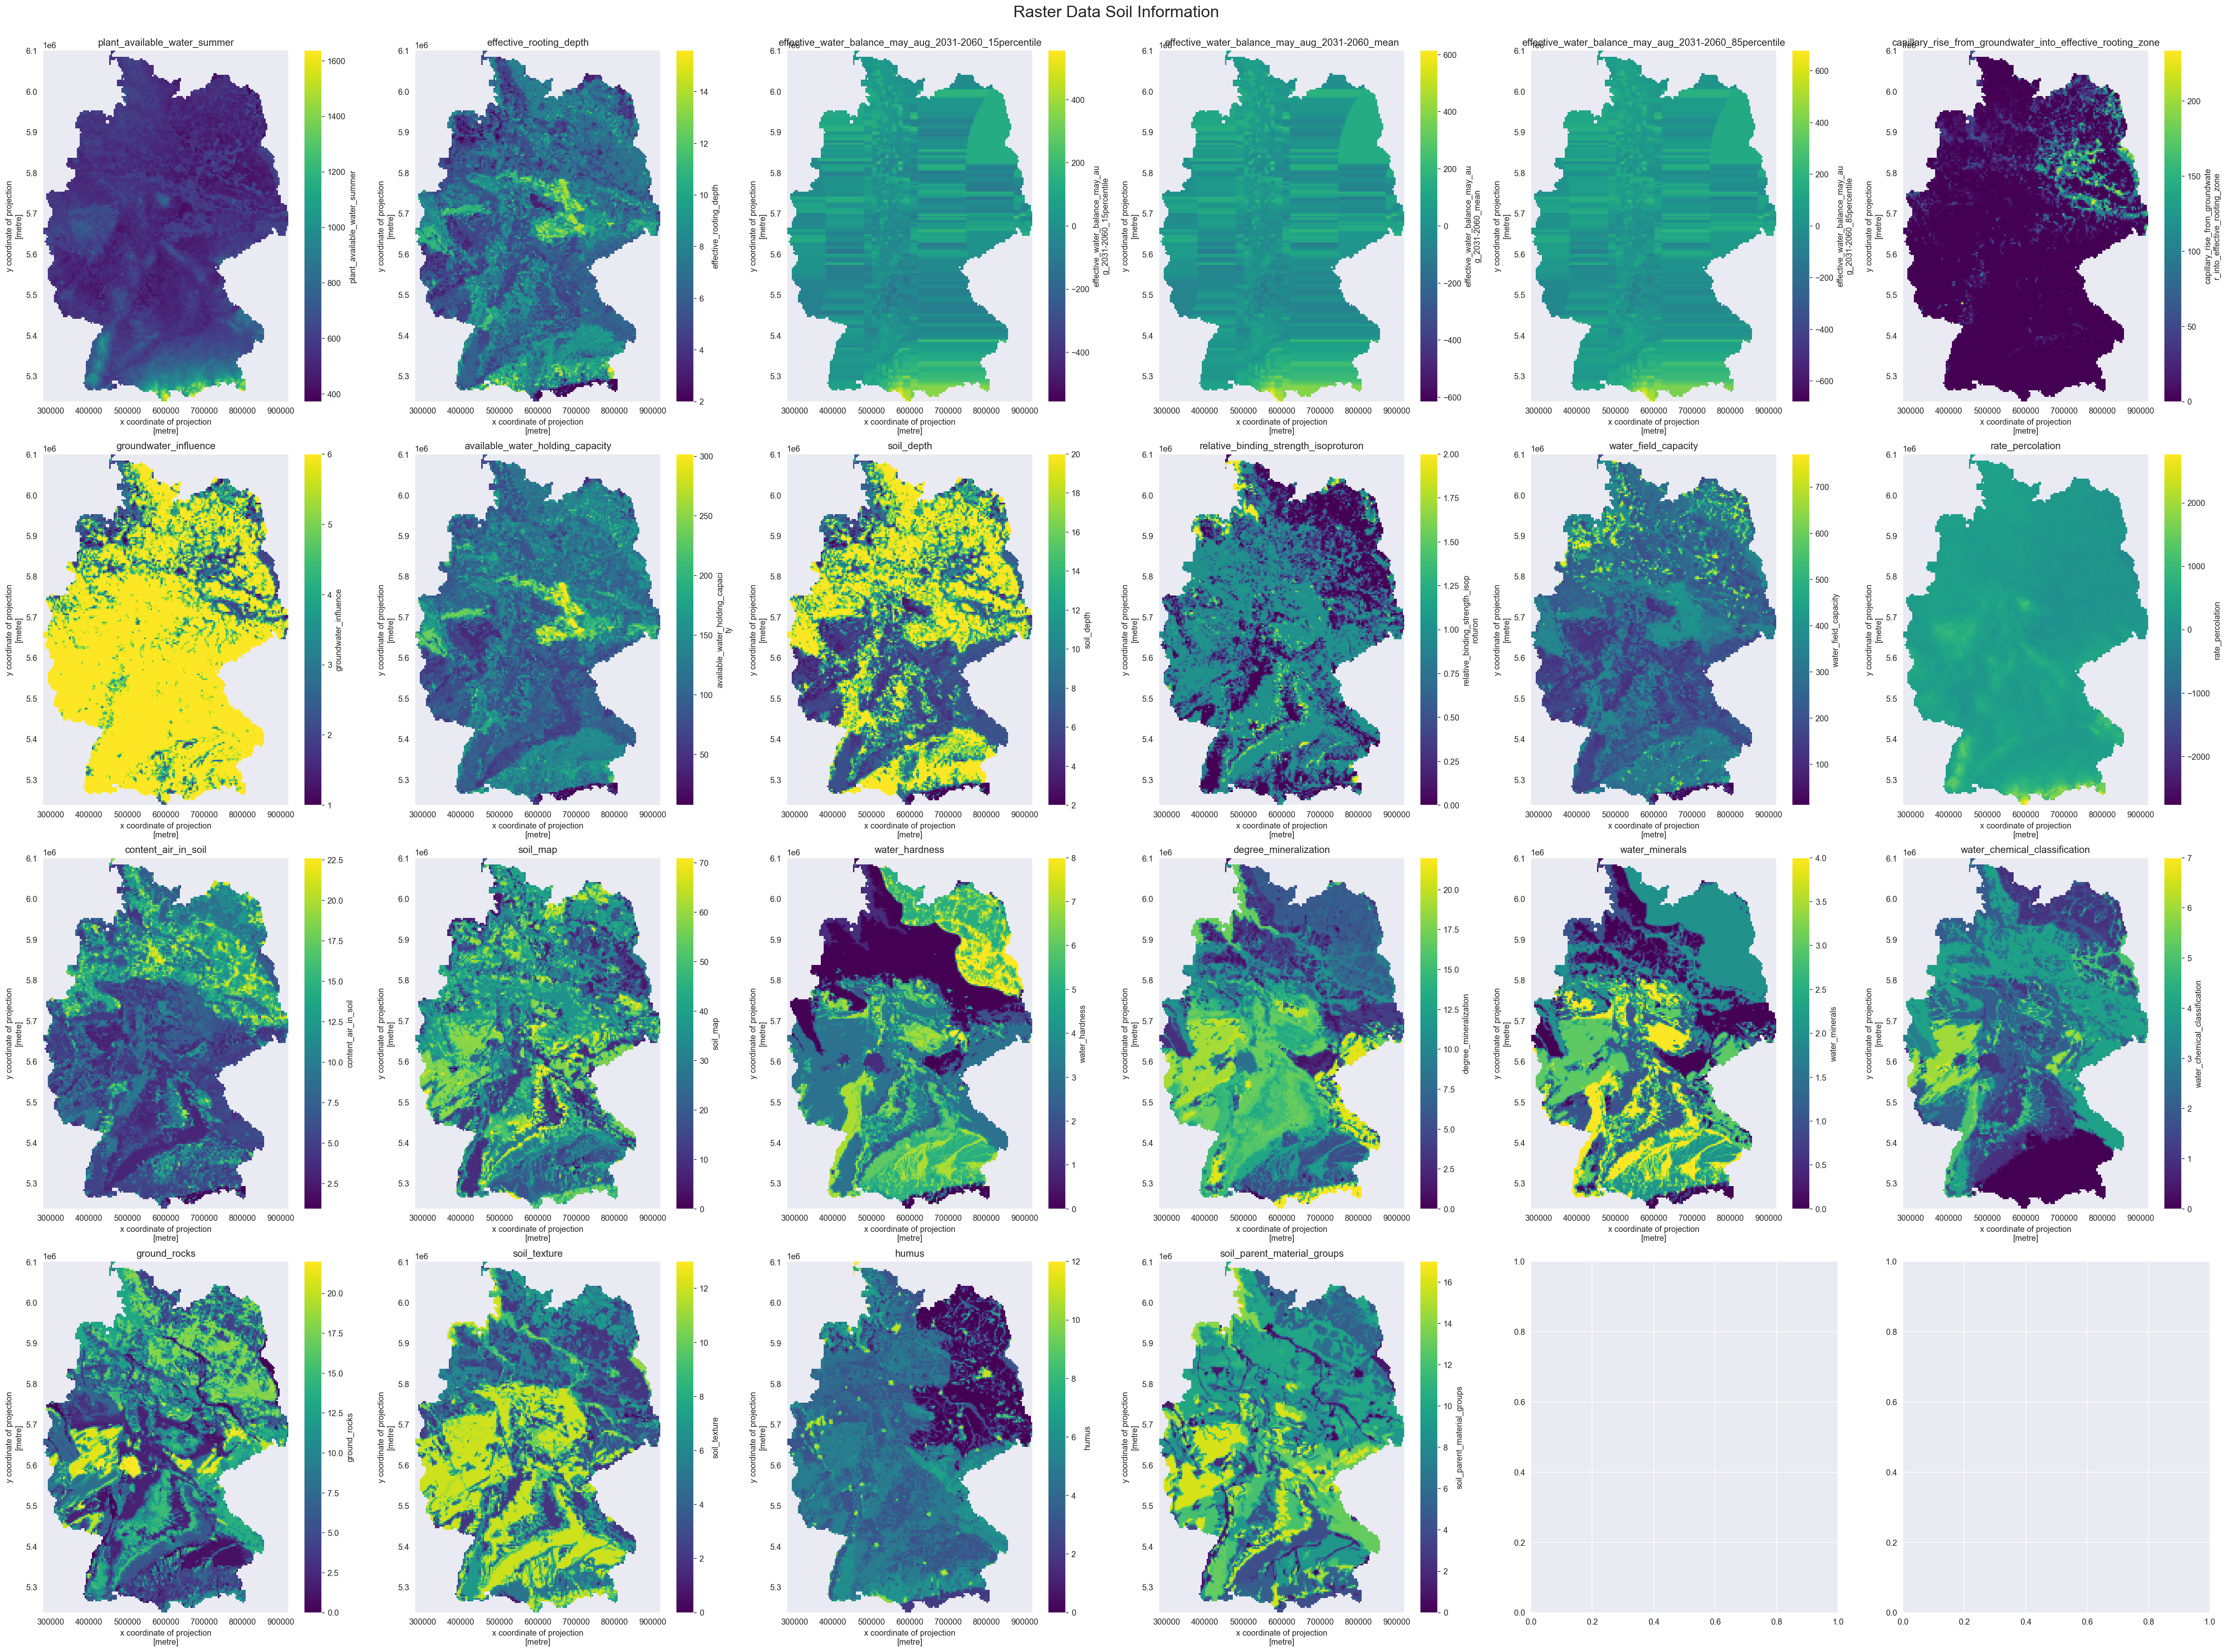

In [18]:
count_rows = 4
count_columns = 6

def plot_grid_soil_data(current_row: int, iteration:int, offset:int, dataset:xr.Dataset, fig, axes):
    try:
        dataset[list(dataset)[iteration + offset]].plot(ax=axes[current_row][iteration], cmap="viridis") # alternate plasma CMRmap
        axes[current_row][iteration].set_title(list(dataset)[iteration + offset])
    except IndexError:
        pass # ignore out of bounds error

fig, axes = plt.subplots(ncols=count_columns, nrows=count_rows, figsize=(int((len(ds_coarsen)/count_rows)*7), 7*count_rows))

for r in range(count_rows):
    for i in range(count_columns):
        plot_grid_soil_data(current_row=r, iteration=i, offset=r*count_columns, dataset=ds_coarsen, fig=fig, axes=axes)

fig.suptitle('Raster Data Soil Information', fontsize=20, y=1)
plt.tight_layout()

In [19]:
# AOI
geodf_aoi = gpd.read_file(f"./data/ThuenenGeoLocations/geolocations_aoi.geojson")
geodf_aoi = geodf_aoi.to_crs("EPSG:32632")
geodf_bf = geodf_aoi.loc[geodf_aoi["bez_wg_bu"] == "Schwarzwald"]

ds_bf = ds.rio.clip(geodf_bf.geometry, geodf_bf.crs)
ds_bf

<xarray.Dataset>
Dimensions:                                                      (y: 633, x: 359)
Coordinates:
  * y                                                            (y) float64 ...
  * x                                                            (x) float64 ...
    spatial_ref                                                  int64 0
Data variables: (12/22)
    plant_available_water_summer                                 (y, x) float32 ...
    effective_rooting_depth                                      (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_15percentile       (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_mean               (y, x) float32 ...
    effective_water_balance_may_aug_2031-2060_85percentile       (y, x) float32 ...
    capillary_rise_from_groundwater_into_effective_rooting_zone  (y, x) float32 ...
    ...                                                           ...
    water_minerals                                               (y, x) float64 ...
    water_chemical_classification                                (y, x) float64 ...
    ground_rocks                                                 (y, x) float64 ...
    soil_texture                                                 (y, x) float64 ...
    humus                                                        (y, x) float64 ...
    soil_parent_material_groups                                  (y, x) float64 ...

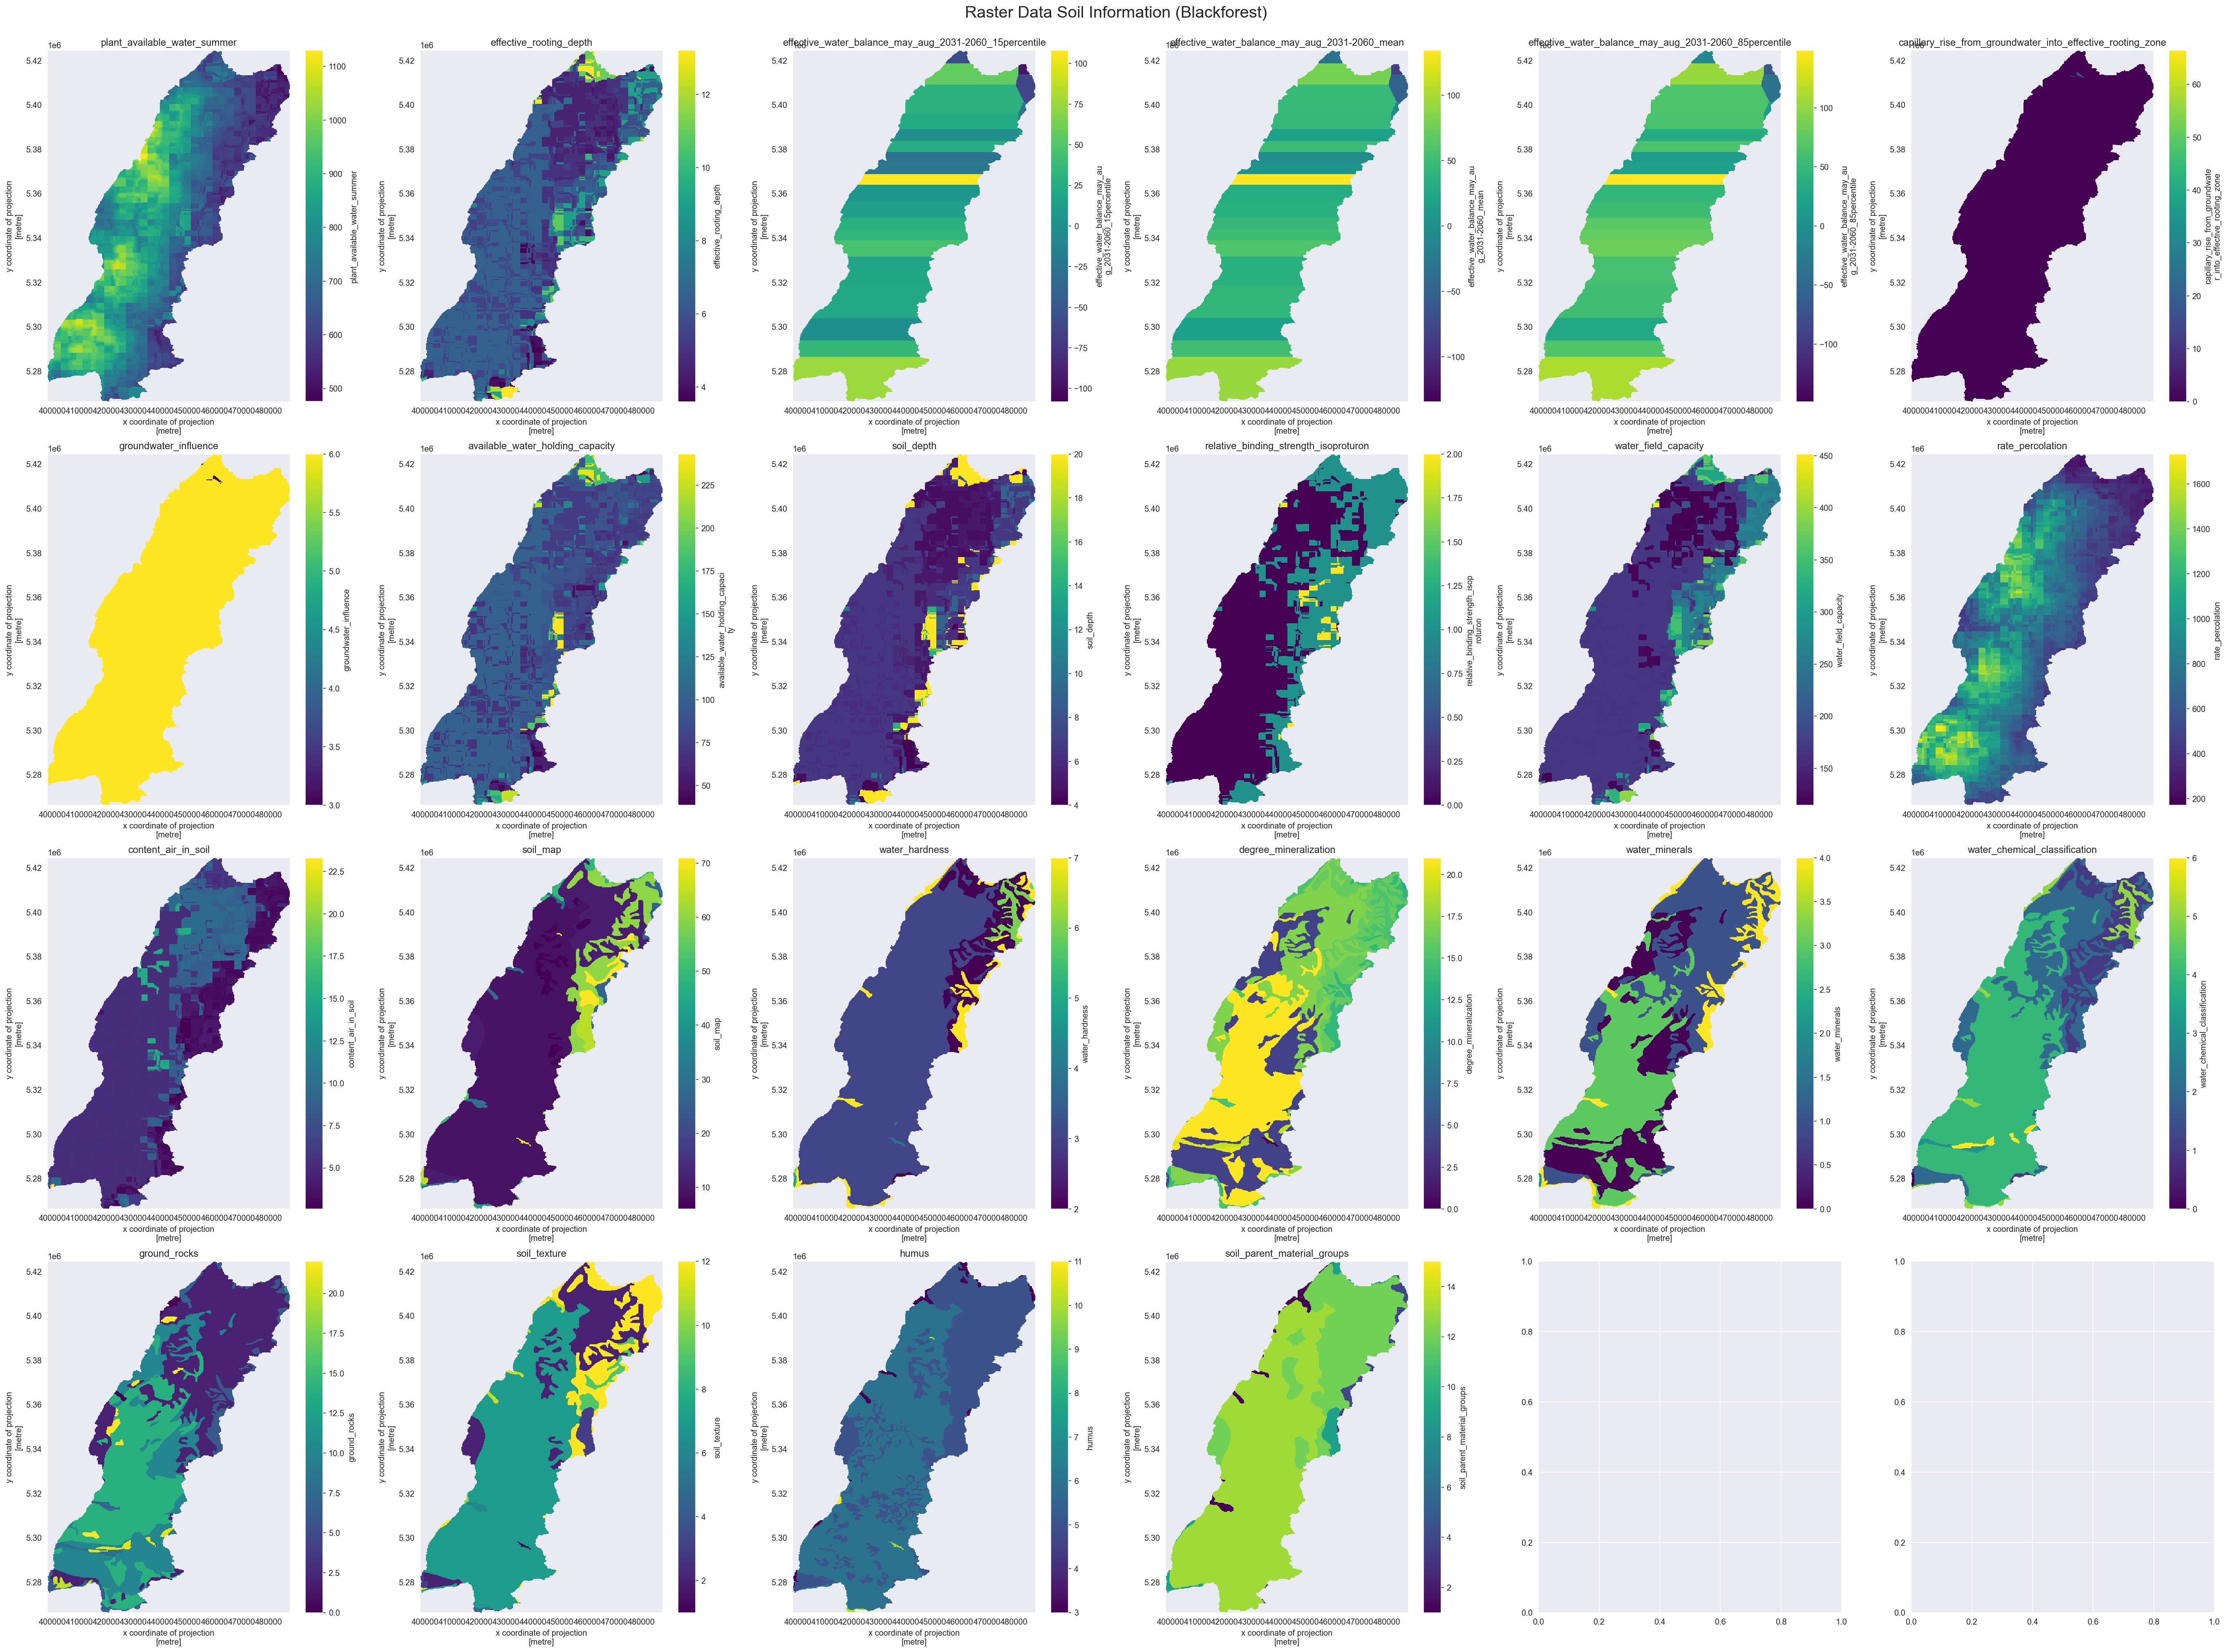

In [20]:
fig, axes = plt.subplots(ncols=count_columns, nrows=count_rows, figsize=(int((len(ds_bf)/count_rows)*7), 7*count_rows))

for r in range(count_rows):
    for i in range(count_columns):
        plot_grid_soil_data(current_row=r, iteration=i, offset=r*count_columns, dataset=ds_bf, fig=fig, axes=axes)

fig.suptitle('Raster Data Soil Information (Blackforest)', fontsize=20, y=1)
plt.tight_layout()